# Part 4: kNN

Predicting passenger survivability of the Titanic route using the kNN classifier

We begin by importing needed libraries. We will use pandas to load and manipulate our data and matplotlib and seaborn to plot our results. 

We will also use sklearn to split the data into test and training set, perform NaN values imputation, standardize, classify and measure our results. Furthermore, the regular expressions module will assist us in extracting some hyperparameter values from a set of metric dictionary string keys.

Despite the fact that we will not be using the numpy and random packages, we will import them only to set a fixed seed for reproducibility.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler # MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
random.seed = 42
np.random.seed(666)

## Data analysis and transformation

We begin by loading our dataset and taking a look at some statistics of it.

In [3]:
titanic_ds = pd.read_csv('titanic.csv')

In [4]:
titanic_ds

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


The Cabin column is missing most of its values, while the Age column is missing about 25% of them.

In [5]:
titanic_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
titanic_ds.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Transformation

We will now begin to transform our data. We will drop the PassengerId, Ticket and Name columns since these contain nominal values and cannot help us in our prediction.

In [7]:
features_to_drop = ['PassengerId', 'Ticket', 'Name']
titanic_ds.drop(features_to_drop, axis=1, inplace=True)

In [8]:
titanic_ds

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B42,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C148,C


We need to verify that every row has a Survived value set. We will also verify that the Sex values are only male and female.

In [9]:
titanic_ds[['Sex', 'Survived']].info(), titanic_ds.Sex.unique(), titanic_ds.Survived.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sex       891 non-null    object
 1   Survived  891 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.0+ KB


(None, array(['male', 'female'], dtype=object), array([0, 1], dtype=int64))

We transform Sex into discrete values. 0 is male, 1 is female.

In [10]:
titanic_ds.Sex = titanic_ds.Sex.factorize()[0]
titanic_ds

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,NaN,S
1,1,1,1,38.0,1,0,71.2833,C85,C
2,1,3,1,26.0,0,0,7.9250,NaN,S
3,1,1,1,35.0,1,0,53.1000,C123,S
4,0,3,0,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,NaN,S
887,1,1,1,19.0,0,0,30.0000,B42,S
888,0,3,1,NaN,1,2,23.4500,NaN,S
889,1,1,0,26.0,0,0,30.0000,C148,C


The Cabin values can also help us in our predictions. Since we cannot use the string values, what we will do is extract only the first character which indicates the deck level of the cabin and sort values based on those first characters. People that had a NaN value are considered to be either traveling without a cabin or not having one specified. In this case we encode those NaN values as zeros.

The intuition behind all this is that based on the deck level of the cabin, the survivability rate varies.

In [11]:
titanic_ds.loc[titanic_ds.Cabin.notna(), 'Cabin'] = titanic_ds.loc[titanic_ds.Cabin.notna(), 'Cabin']\
                                                       .astype(str).str[0].factorize(sort=True)[0] + 1
titanic_ds.loc[titanic_ds.Cabin.isna(), 'Cabin'] = 0
titanic_ds.Cabin = titanic_ds.Cabin.astype(int)

In [12]:
titanic_ds

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,0,S
1,1,1,1,38.0,1,0,71.2833,3,C
2,1,3,1,26.0,0,0,7.9250,0,S
3,1,1,1,35.0,1,0,53.1000,3,S
4,0,3,0,35.0,0,0,8.0500,0,S
...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,0,S
887,1,1,1,19.0,0,0,30.0000,2,S
888,0,3,1,NaN,1,2,23.4500,0,S
889,1,1,0,26.0,0,0,30.0000,3,C


We also encode the Embarked values. These values indicate the location each passenger boarded from. This could not possibly help us much but we are going to use those values anyway.

Titanic started her journey from Southampton, Hampshire (value S), continued to Chesbourg, France (value C) and concluded in Queenstown, Ireland (value Q) before eventually sinking. By factorizing (discretizing) those values we get S as a 0, C as a 1 and Q as a 2, which is exactly the course of Titanic's journey in that order.

In [13]:
titanic_ds.loc[titanic_ds.Embarked.notna(), 'Embarked'] = titanic_ds.loc[titanic_ds.Embarked.notna(), 'Embarked']\
                                                            .astype(str).str[0].factorize()[0]
titanic_ds.Embarked = titanic_ds.Embarked.astype(float)

Finally, we standardize all values besides the outcome column, which is Survived.

In [14]:
titanic_ds.loc[:, titanic_ds.columns != 'Survived'] = \
                StandardScaler().fit_transform(titanic_ds.loc[:, titanic_ds.columns != 'Survived'])

In [15]:
titanic_ds

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,0.827377,-0.737695,-0.530377,0.432793,-0.473674,-0.502445,-0.488461,-0.569684
1,1,-1.566107,1.355574,0.571831,0.432793,-0.473674,0.786845,1.398325,1.003139
2,1,0.827377,1.355574,-0.254825,-0.474545,-0.473674,-0.488854,-0.488461,-0.569684
3,1,-1.566107,1.355574,0.365167,0.432793,-0.473674,0.420730,1.398325,-0.569684
4,0,0.827377,-0.737695,0.365167,-0.474545,-0.473674,-0.486337,-0.488461,-0.569684
...,...,...,...,...,...,...,...,...,...
886,0,-0.369365,-0.737695,-0.185937,-0.474545,-0.473674,-0.386671,-0.488461,-0.569684
887,1,-1.566107,1.355574,-0.737041,-0.474545,-0.473674,-0.044381,0.769396,-0.569684
888,0,0.827377,1.355574,NaN,0.432793,2.008933,-0.176263,-0.488461,-0.569684
889,1,-1.566107,-0.737695,-0.254825,-0.474545,-0.473674,-0.044381,1.398325,1.003139


Let's take a look inside our data once more.

In [16]:
titanic_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    float64
 2   Sex       891 non-null    float64
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    float64
 5   Parch     891 non-null    float64
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    float64
 8   Embarked  889 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 62.8 KB


In [17]:
titanic_ds.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,8.910000e+02,8.910000e+02,7.140000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.890000e+02
mean,0.383838,-2.031048e-16,3.162453e-16,2.174187e-16,3.456519e-16,6.716164e-17,-4.373606e-17,1.369400e-16,-1.578540e-16
std,0.486592,1.000562e+00,1.000562e+00,1.000701e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000563e+00
min,0.000000,-1.566107e+00,-7.376951e-01,-2.016979e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,-4.884607e-01,-5.696840e-01
25%,0.000000,-3.693648e-01,-7.376951e-01,-6.595416e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,-4.884607e-01,-5.696840e-01
50%,0.000000,8.273772e-01,-7.376951e-01,-1.170488e-01,-4.745452e-01,-4.736736e-01,-3.573909e-01,-4.884607e-01,-5.696840e-01
75%,1.000000,8.273772e-01,1.355574e+00,5.718310e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,-4.884607e-01,1.003139e+00
max,1.000000,8.273772e-01,1.355574e+00,3.465126e+00,6.784163e+00,6.974147e+00,9.667167e+00,4.542967e+00,2.575963e+00


Now let's look at the correlation between all features.

As expected, the passenger class is correlated with the cabin and fare values. There also seems to be a survivability bias towards female passengers and people that paid a larger fare and had a more prestigious cabin.

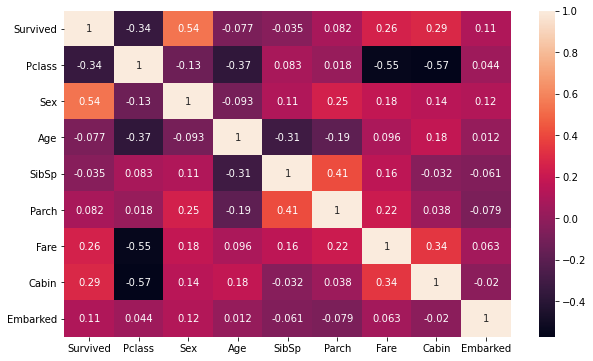

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(titanic_ds.corr(), annot=True);

## Training

Let's now proceed with training some models.

### With dropped values

First, we will train by simply dropping all NaN values.

In [19]:
clean_titanic_ds = titanic_ds.dropna()

In [20]:
clean_titanic_ds.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,-0.081945,0.023761,-0.003928,-0.008132,0.063295,0.047579,0.065385,-0.158806
std,0.491139,1.001499,1.007742,0.998389,0.844453,1.060298,1.065903,1.052941,0.820323
min,0.000000,-1.566107,-0.737695,-2.016979,-0.474545,-0.473674,-0.648422,-0.488461,-0.569684
25%,0.000000,-1.566107,-0.737695,-0.668153,-0.474545,-0.473674,-0.486337,-0.488461,-0.569684
50%,0.000000,-0.369365,-0.737695,-0.117049,-0.474545,-0.473674,-0.333397,-0.488461,-0.569684
75%,1.000000,0.827377,1.355574,0.571831,0.432793,0.767630,0.016023,0.140468,-0.569684
max,1.000000,0.827377,1.355574,3.465126,4.062148,6.974147,9.667167,4.542967,2.575963


We extract the features and the targets out of our dataset. In this case the targets should be the Survived column.

In [21]:
features = clean_titanic_ds.drop(columns='Survived')
targets = clean_titanic_ds.Survived.astype('bool')

We split our data into training and test set.

In [22]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, stratify=targets)

#### Modeling

And proceed by creating our models.

For this, we set some hyperparameters. We will use the k-nearest neighbours model with several kinds of different hyperparameter values.

We create several model combinations with:
* Number of different neighbours ranging from 1 to 200
* Weights of nearest neighbours either being uniform or based on the neighbour distance
* The distance between neighbours being measured as either the L1 norm (Manhattan distance) or the L2 norm (Euclidean distance)

In [23]:
neighbours_step = 1
max_neighbours = 200
neighbour_range = list(range(neighbours_step, max_neighbours + neighbours_step, neighbours_step))
weights_range = ['uniform', 'distance']
p_range = [1, 2]

We create a function that will build and return a dictionary of models based on all these parameters.

In [24]:
def make_models():
    all_models = dict()
    for weights in weights_range:
        for p in p_range:
            key = 'w' + weights.capitalize() + '_p' + str(p)
            models = dict([(key + '_n' + str(n), 
                            KNeighborsClassifier(n_neighbors=n, weights=weights, p=p, n_jobs=4)) 
                           for n in neighbour_range])
            all_models[key] = models
    return all_models

So, we make our models

In [25]:
all_models = make_models()

and proceed to train them.

In [26]:
[model.fit(x_train, y_train) for models in all_models.values() for model in models.values()]

[KNeighborsClassifier(n_jobs=4, n_neighbors=1, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=2, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=3, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=4, p=1),
 KNeighborsClassifier(n_jobs=4, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=6, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=7, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=8, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=9, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=10, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=11, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=12, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=13, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=14, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=15, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=16, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=17, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=18, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=19, p=1)

To measure our models' results we also build a function that will return for us their test and train predictions and metrics (accuracy, precision, recall and F1 score in that order).

In [27]:
def make_predictions_and_metrics():
    """
    Returns dictionaries of test and train predictions and metrics (accuracy, precision, recall and f1 
    in that order)
    """
    y_predicted_test = dict()
    test_acc = dict()
    test_prec = dict()
    test_rec = dict()
    test_f1 = dict()

    y_predicted_train = dict()
    train_acc = dict()
    train_prec = dict()
    train_rec = dict()
    train_f1 = dict()
    for weights in weights_range:
        for p in p_range:
            key = 'w' + weights.capitalize() + '_p' + str(p)

            test_predicted_values = {item[0]:item[1].predict(x_test) 
                                  for item in all_models[key].items()}
            y_predicted_test[key] = test_predicted_values
            test_acc[key] = {item[0]:metrics.accuracy_score(y_test, item[1]) 
                            for item in test_predicted_values.items()}
            test_prec[key] = {item[0]:metrics.precision_score(y_test, item[1], average='macro') 
                            for item in test_predicted_values.items()}
            test_rec[key] = {item[0]:metrics.recall_score(y_test, item[1], average='macro') 
                            for item in test_predicted_values.items()}
            test_f1[key] = {item[0]:metrics.f1_score(y_test, item[1], average='macro') 
                            for item in test_predicted_values.items()}


            train_predicted_values = {item[0]:item[1].predict(x_train) 
                                  for item in all_models[key].items()}
            y_predicted_train[key] = train_predicted_values
            train_acc[key] = {item[0]:metrics.accuracy_score(y_train, item[1]) 
                            for item in train_predicted_values.items()}
            train_prec[key] = {item[0]:metrics.precision_score(y_train, item[1], average='macro') 
                            for item in train_predicted_values.items()}
            train_rec[key] = {item[0]:metrics.recall_score(y_train, item[1], average='macro') 
                            for item in train_predicted_values.items()}
            train_f1[key] = {item[0]:metrics.f1_score(y_train, item[1], average='macro') 
                            for item in train_predicted_values.items()}

    return ({'test': y_predicted_test, 'train': y_predicted_train}, 
    {'test': test_acc, 'train': train_acc},
    {'test': test_prec, 'train': train_prec},
    {'test': test_rec, 'train': train_rec},
    {'test': test_f1, 'train': train_f1})

We make the predictions and metric evaluations.

In [28]:
y_predicted, accuracy, precision, recall, f1 = make_predictions_and_metrics()

We also create a function that will plot the F1 score against the number of neighbours, for each type of models.

In [29]:
def plot_knn_metrics(metrics, metric_name):
    for key in metrics['test']:
        weights = re.search("(?<=^w)\w+(?=_p)", key).group()
        p = re.search('(?<=_p)\d+$', key).group()
        
        plt.figure(figsize=(10,6))
        plt.plot(neighbour_range, metrics['test'][key].values())
        plt.plot(metrics['train'][key].values())
        plt.title('F1 vs number of neighbours\n' +
                  'Weights: ' + weights + ', p: '+ p)
        plt.legend(['Test ' + metric_name, 'Train ' + metric_name])
        plt.xlabel('Number of neighbours')
        plt.ylabel(metric_name)
        plt.show()

Then, we plot.

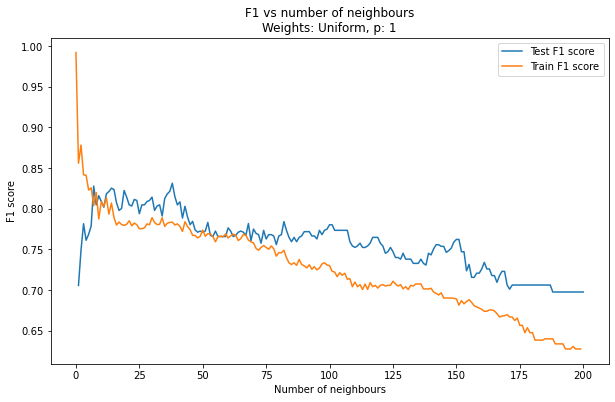

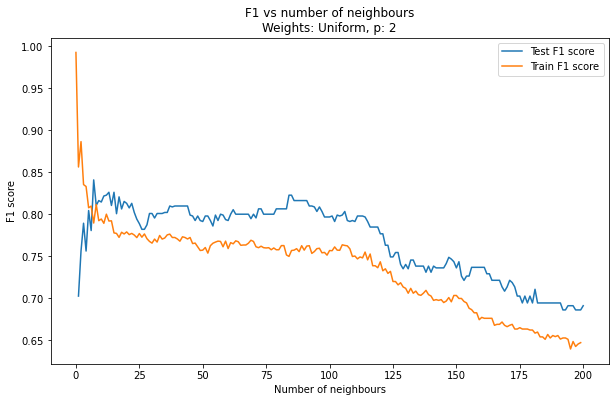

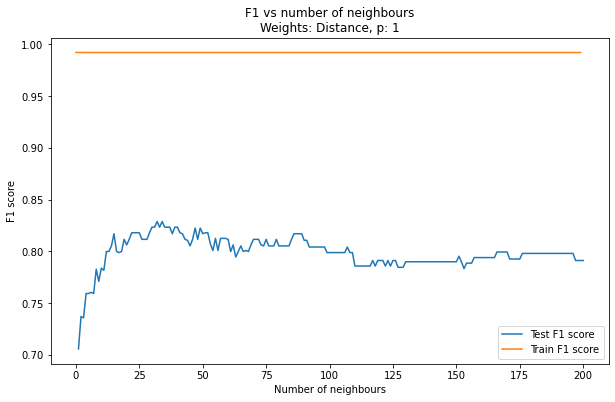

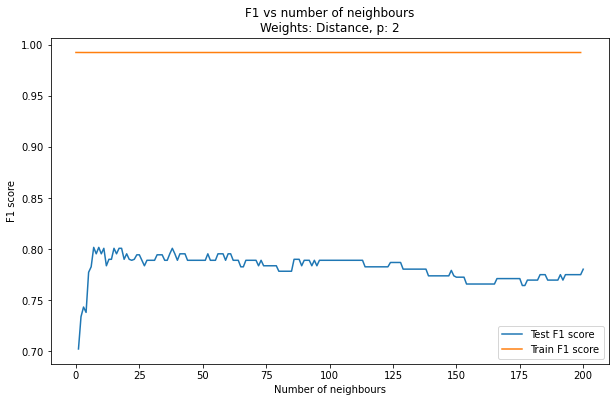

In [30]:
plot_knn_metrics(f1, "F1 score")

Another function will help us detect the hyperparameters and metric values of the best model (highest F1 score) from each type of models.

In [31]:
def find_maxF1_metrics():
    max_metrics_list = []
    for key in f1['test']:
        max_metrics = dict()
        
        max_f1_key = max(f1['test'][key], key=f1['test'][key].get)
        
        weights = re.search("(?<=^w)\w+(?=_p)", max_f1_key).group().lower()
        p = re.search('(?<=_p)\d+(?=_n)', max_f1_key).group()
        n = re.search("(?<=_n)\d+$", max_f1_key).group()
        max_metrics['weights'] = weights
        max_metrics['p'] = int(p)
        max_metrics['n'] = int(n)
        
        max_metrics['accuracy'] = accuracy['test'][key][max_f1_key]
        max_metrics['precision'] = precision['test'][key][max_f1_key]
        max_metrics['recall'] = recall['test'][key][max_f1_key]
        max_metrics['f1'] = f1['test'][key][max_f1_key]
        
        max_metrics_list.append(max_metrics)
    
    return max_metrics_list

All of our models did pretty well, with the ones having uniform weights making the best predictions overall.

In [32]:
find_maxF1_metrics()

[{'weights': 'uniform',
  'p': 1,
  'n': 38,
  'accuracy': 0.8426966292134831,
  'precision': 0.848587570621469,
  'recall': 0.8233752620545074,
  'f1': 0.8314393939393938},
 {'weights': 'uniform',
  'p': 2,
  'n': 7,
  'accuracy': 0.848314606741573,
  'precision': 0.8458383756891219,
  'recall': 0.8370020964360587,
  'f1': 0.8406657162749063},
 {'weights': 'distance',
  'p': 1,
  'n': 32,
  'accuracy': 0.8370786516853933,
  'precision': 0.8338711846174534,
  'recall': 0.8253406708595388,
  'f1': 0.8288631767397142},
 {'weights': 'distance',
  'p': 2,
  'n': 7,
  'accuracy': 0.8089887640449438,
  'precision': 0.8017557651991614,
  'recall': 0.8017557651991614,
  'f1': 0.8017557651991615}]

### With imputation

Let's repeat the procedure using value imputation for the missing values in our dataset.

For this we will use the k-nearest neighbours imputer, with the imputated value depending on the 3 closest neighbours.

In [33]:
imputated_titanic_ds = titanic_ds
imputated_titanic_ds[:] = KNNImputer(n_neighbors=3).fit_transform(titanic_ds)

In [34]:
imputated_titanic_ds.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,8.910000e+02,8.910000e+02,891.000000,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000
mean,0.383838,-2.031048e-16,3.162453e-16,0.010466,3.456519e-16,6.716164e-17,-4.373606e-17,1.369400e-16,-0.000690
std,0.486592,1.000562e+00,1.000562e+00,0.988058,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,0.999621
min,0.000000,-1.566107e+00,-7.376951e-01,-2.016979,-4.745452e-01,-4.736736e-01,-6.484217e-01,-4.884607e-01,-0.569684
25%,0.000000,-3.693648e-01,-7.376951e-01,-0.599265,-4.745452e-01,-4.736736e-01,-4.891482e-01,-4.884607e-01,-0.569684
50%,0.000000,8.273772e-01,-7.376951e-01,-0.117049,-4.745452e-01,-4.736736e-01,-3.573909e-01,-4.884607e-01,-0.569684
75%,1.000000,8.273772e-01,1.355574e+00,0.571831,4.327934e-01,-4.736736e-01,-2.424635e-02,-4.884607e-01,1.003139
max,1.000000,8.273772e-01,1.355574e+00,3.465126,6.784163e+00,6.974147e+00,9.667167e+00,4.542967e+00,2.575963


By examining our feature correlations again, we cannot detect much of an important difference compared to the original dataset.

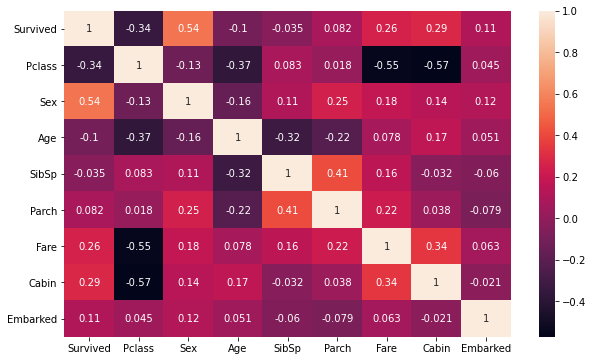

In [35]:
plt.figure(figsize=(10,6))
sns.heatmap(imputated_titanic_ds.corr(), annot=True);

Again, we split into features and targets,

In [36]:
features = imputated_titanic_ds.drop(columns='Survived')
targets = imputated_titanic_ds.Survived.astype('bool')

split into training and test sets,

In [37]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, stratify=targets)

make and train all our models,

In [38]:
all_models = make_models()
[model.fit(x_train, y_train) for models in all_models.values() for model in models.values()]

[KNeighborsClassifier(n_jobs=4, n_neighbors=1, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=2, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=3, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=4, p=1),
 KNeighborsClassifier(n_jobs=4, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=6, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=7, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=8, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=9, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=10, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=11, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=12, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=13, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=14, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=15, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=16, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=17, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=18, p=1),
 KNeighborsClassifier(n_jobs=4, n_neighbors=19, p=1)

make predictions and evaluations,

In [39]:
y_predicted, accuracy, precision, recall, f1 = make_predictions_and_metrics()

and finally, plot.

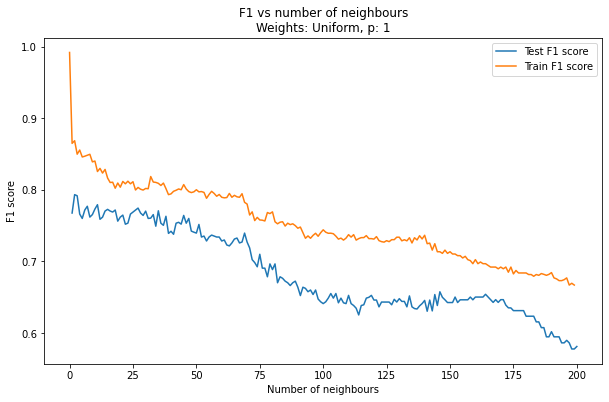

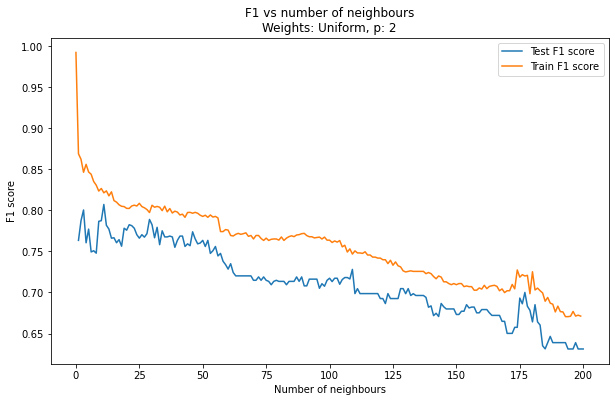

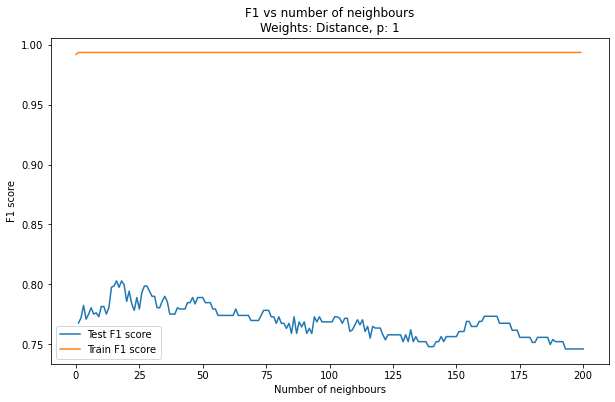

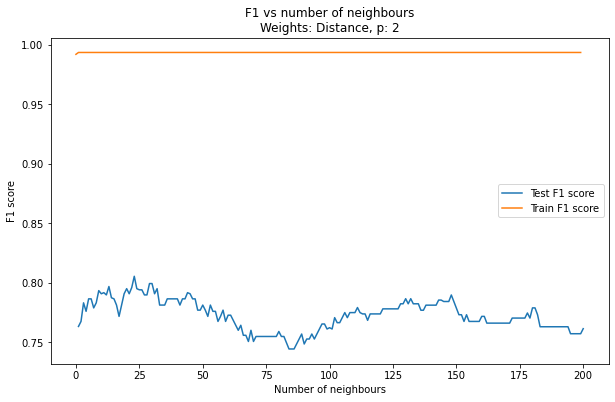

In [40]:
plot_knn_metrics(f1, "F1 score")

Overall, there is not much of a significant deviation in the evaluation compared to the models that were trained using only rows with non-NaN values.

In [41]:
find_maxF1_metrics()

[{'weights': 'uniform',
  'p': 1,
  'n': 2,
  'accuracy': 0.820627802690583,
  'precision': 0.8505667236954662,
  'recall': 0.778263452724495,
  'f1': 0.7933654558932541},
 {'weights': 'uniform',
  'p': 2,
  'n': 11,
  'accuracy': 0.820627802690583,
  'precision': 0.8146772767462422,
  'recall': 0.8020709556951282,
  'f1': 0.807126794672202},
 {'weights': 'distance',
  'p': 1,
  'n': 16,
  'accuracy': 0.8161434977578476,
  'precision': 0.8090717299578059,
  'recall': 0.7984213206586318,
  'f1': 0.8028038391027715},
 {'weights': 'distance',
  'p': 2,
  'n': 23,
  'accuracy': 0.8161434977578476,
  'precision': 0.8062659846547314,
  'recall': 0.804914276014259,
  'f1': 0.8055715045188729}]